In [1]:
from collections import OrderedDict
import copy
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.optimize as spopt
import platereaderdataloader as prdl

%matplotlib inline

# Table of Contents
* [Description of the Long Term Evolution Experiment](#Description-of-the-Long-Term-Evolution-Experiment)
  * [Typical Growth Curve](#Typical-Growth-Curve)
* [Patterns of evolution of growth rate and saturating optical density](#Patterns-of-evolution-of-growth-rate-and-saturating-optical-density)
  * [Evolution of the growth rate](#Evolution-of-the-growth-rate)
  * [Evolution of saturating OD](#Evolution-of-saturating-OD)
* [Evolution of a single replicate's growth curves](#Evolution-of-a-single-replicate's-growth-curves)


# Description of the Long Term Evolution Experiment

The long term evolution experiment (short compared to Lenski) was similar to Lenski's experiment. I started with a single strain of *E. coli* and split it into 45 populations that each grew in 500 microliters of supplemented M9 medium at 30 degrees Celsius in a platereader each day. There were also 3 black wells. Over the course of the day, the E. coli consume their food and the platereader measures the optical density of the *E. coli* every ~10 minutes. At the end of each day, all 45 populations are diluted 500x and put into a fresh well of 500 microliters then back in the platereader.

Every three days, a sample of all populations is frozen in case of mishap. Twice the experiment was stopped, all stocks were frozen, and then the experiment was resumed later. Let's look at the growth curve data.

What makes this experiment different from Lenski's is that the strain of *E. coli* used has an adjustable mutation rate tuned by otherwise innocuous chemical inducers. 5 combinations of inducer concentrations were chosen giving 5 mutation rates with 9 replicates of each. Thus, for an otherwise fixed strain of *E. coli* we can see how the mutation rate affects evolution.

First I need to import the data.

In [2]:
cd "Experiment 1"

/home/kuhlmanlab/Documents/Long Term Evolution Experiments/Experiment 1


In [3]:
days = OrderedDict()

filename_end = ' July 2018 NS001 delta CAT 30 C.xlsx'
platelayout1 = ['0,0,'+str(i) for i in range(1,10)] + ['50,0,'+str(i) for i in range(1,10)] + \
               ['2000,0,'+str(i) for i in range(1,10)] + ['2000,2,'+str(i) for i in range(1,10)] + \
               ['2000,10,'+str(i) for i in range(1,10)] + ['blank1', 'blank2', 'blank3']
platelayout2 = ['2000,0,'+str(i) for i in range(1,10)] + ['2000,2,'+str(i) for i in range(1,10)] + \
               ['2000,10,'+str(i) for i in range(1,10)]  + ['50,0,'+str(i) for i in range(1,10)] + \
               ['0,0,'+str(i) for i in range(1,10)] + ['blank1', 'blank2', 'blank3']

for i in range(9,10):
    filename = str(i) + filename_end
    platelayout180 = copy.copy(platelayout1)
    platelayout180.reverse() # I accidnentally rotated the plate 180 degrees this day
    days[i-9] = prdl.import_platereader(filename, platelayout180)

for i in range(10,19):
    filename = str(i) + filename_end
    days[i-9] = prdl.import_platereader(filename,platelayout1)

In [4]:
cd ..

/home/kuhlmanlab/Documents/Long Term Evolution Experiments


In [5]:
cd "Experiment 1 Branch off July 18"

/home/kuhlmanlab/Documents/Long Term Evolution Experiments/Experiment 1 Branch off July 18


In [6]:
filename_end_branch = ' 2018 NS001 delta CAT mutation rate titrations.xlsx'

platelayout_branch = platelayout1

treatments = copy.deepcopy(platelayout_branch)
treatments.remove('blank1')
treatments.remove('blank2')
treatments.remove('blank3')
        
for i in range(0,8):
    filename = str(i+24) + ' August' + filename_end_branch
    days[i+10]=prdl.import_platereader(filename, platelayout_branch)

for i in range(8,17):
    filename = str(i-7) + ' September' + filename_end_branch
    days[i+10]=prdl.import_platereader(filename, platelayout_branch)

In [7]:
cd ..

/home/kuhlmanlab/Documents/Long Term Evolution Experiments


In [8]:
cd "Experiment 1 Branch 1 Continued 28 Sept"

/home/kuhlmanlab/Documents/Long Term Evolution Experiments/Experiment 1 Branch 1 Continued 28 Sept


In [9]:
filename_end_continue = ' 2018 NS001 delta CAT mutation rate titrations.xlsx'
        
for i in range(0,4):
    filename = str(i+27) + ' September' + filename_end_branch
    days[i+27]=prdl.import_platereader(filename, platelayout_branch)

for i in range(4,15):
    filename = str(i-3) + ' October' + filename_end_branch
    days[i+27] = prdl.import_platereader(filename, platelayout_branch)

The days are numbered 0 through 41. The replicates are named with a string describing the concentrations of the two inducers separated by commas and then a replicate number. So "x,y,i" where x is the concentration of IPTG in micromolar, y is the concentration of aTc in nanograms per milliliter, and i is the replicate number which ranges from 1-9.

From lowest to highest mutation rate the x,y pairs are (2000,10), (2000,2), (2000,0), (50,0), and (0,0).

## Typical Growth Curve
<font size=\"1\">[Return to Table of Contents](#Table-of-Contents)</font>

A typical growth curve for as single replicate over a single day looks something like this.

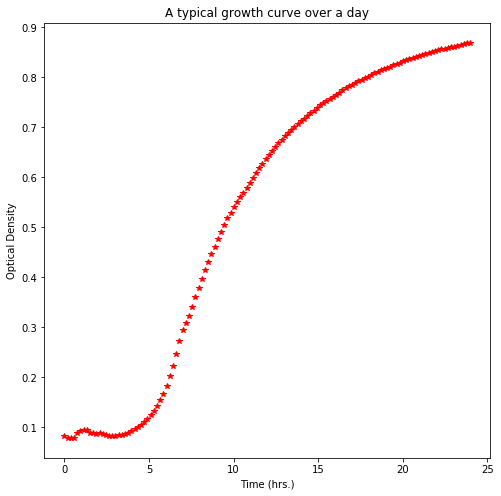

In [10]:
typical_day = 1
typical_replicate = '2000,0,1'
t = days[typical_day]['times']
P = days[typical_day]['well_ODs'][typical_replicate]
plt.figure(figsize=(8,8));
plt.plot(t, P, 'r*');
plt.ylabel('Optical Density');
plt.xlabel('Time (hrs.)');
plt.title('A typical growth curve over a day');

Optical density (OD) is roughly some constant plus a term proportional to population density as long as the cell size distribution remains unchanged. Unfortunately, it probably changes as the population consumes most of its food and the optical density starts saturating. However, we'll treat optical density as a proxy for P. If we plot dOD/dt vs. OD we should be able to see roughly what sort of population dynamics are occurring. We'll need to subtract the OD of 0 population to get a measure proportional to P.

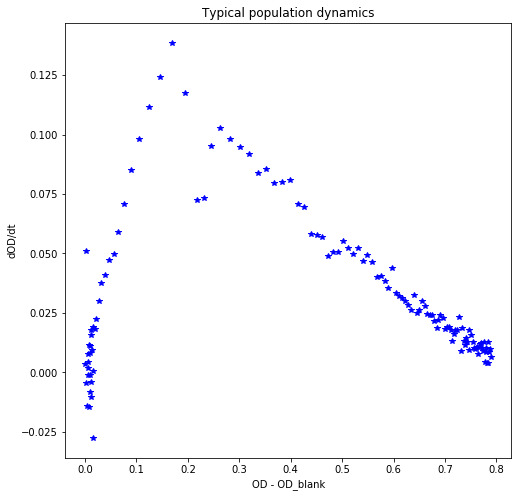

In [11]:
typical_day = 1
typical_replicate = '2000,0,1'
t = days[typical_day]['times']
P = days[typical_day]['well_ODs'][typical_replicate]
dP_dt = np.diff(P)/np.diff(t)
P_blanked = P - .99*np.min(P)
plt.figure(figsize=(8,8))
plt.plot(P_blanked[:-1], dP_dt, 'b*')
plt.ylabel('dOD/dt');
plt.xlabel('OD - OD_blank');
plt.title('Typical population dynamics');

This plot is highly suggestive of exponential growth at low OD followed by a swift decrease in growth at higher OD. Higher OD's look like negative exponential growth although how much of that is due to population changes and how much due to a change in the size distribution is currently unknown.

Of course, we should check whether the curves I've shown above are typical.

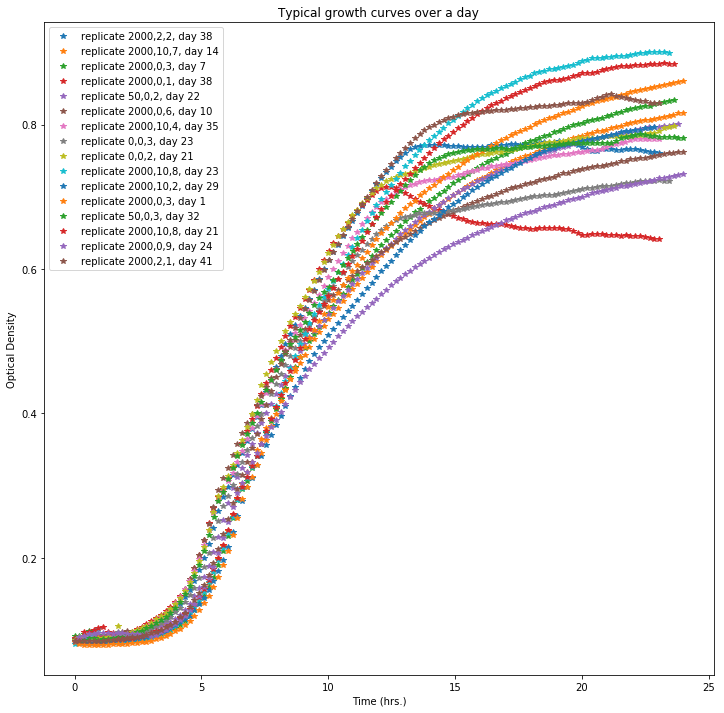

In [12]:
plt.figure(figsize=(12,12))
typical_days = []
typical_replicates = []
np.random.seed(42)
for i in range(4):
    for j in range(4):
        typical_day = np.random.randint(42)
        typical_days.append(typical_day)
        typical_replicate = treatments[np.random.randint(45)]
        typical_replicates.append(typical_replicate)
        t = days[typical_day]['times']
        P = days[typical_day]['well_ODs'][typical_replicate]
        plt.plot(t, P, '*', label = 'replicate {}, day {}'.format(typical_replicate, typical_day))
plt.ylabel('Optical Density');
plt.xlabel('Time (hrs.)');
plt.title('Typical growth curves over a day');
plt.legend();

And the curves of dOD_dt vs OD.

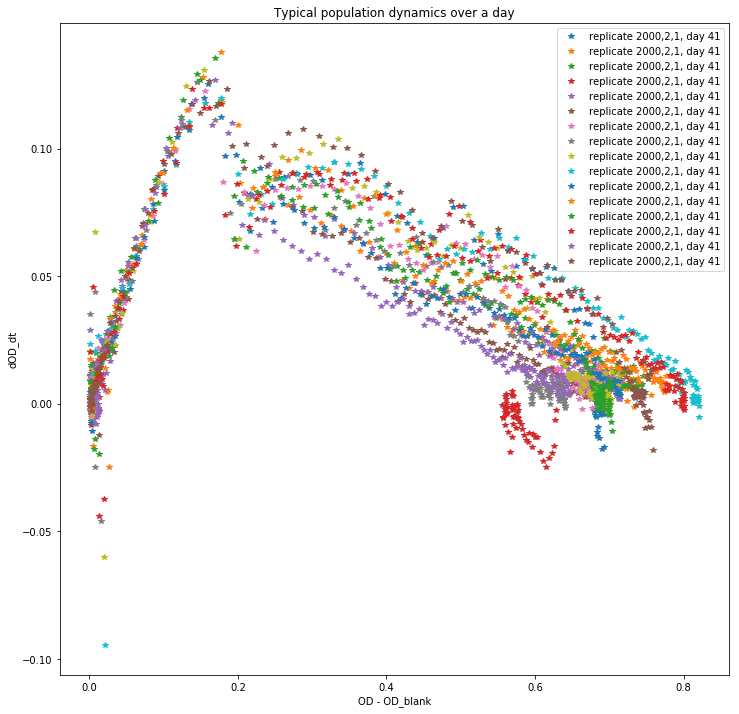

In [13]:
plt.figure(figsize=(12,12))
for day, replicate in zip(typical_days, typical_replicates):
        t = days[day]['times']
        P = days[day]['well_ODs'][replicate]
        dP_dt = np.diff(P)/np.diff(t)
        P_blanked = P - .99*np.min(P)
        plt.plot(P_blanked[:-1], dP_dt, '*', label = 'replicate {}, day {}'.format(typical_replicate, typical_day))
plt.ylabel('dOD_dt');
plt.xlabel('OD - OD_blank');
plt.title('Typical population dynamics over a day');
plt.legend();

We can see that typical growth curves have an exponential growth phase followed by saturation although some curves actually show a drop in optical density at the end. There are also many outliers on days I unfreeze cells and resume and a few other unexplained outliers out of hundreds of curves.

# Patterns of evolution of growth rate and saturating optical density
<font size=\"1\">[Return to Table of Contents](#Table-of-Contents)</font>

This suggests that I can extract simplified parameters for each days growth. I fit a positive exponential to the begining of each growth curve and a negative exponential to the end of each growth curve.

In [14]:
def shifted_exp(t, P0, r, C):
    return P0*np.exp(r*t)+C

def exp(t, P0, r):
    return P0*np.exp(r*t)

def estimate_blank(data):
    blanks = []
    for key in data:
        b1 = np.mean(data[key]['well_ODs']['blank1'])
        b2 = np.mean(data[key]['well_ODs']['blank2'])
        b3 = np.mean(data[key]['well_ODs']['blank3'])
        blanks.append(np.median(np.array([b1,b2,b3])))
    return np.median(np.array(blanks))

def fit_phases(t, P, cut_below, cut_above, blank=None):
    try:
        i1 = np.where(P<cut_below)[0][0]+1
    except IndexError:
        i1 = 0
    i2 = np.where(P>cut_above)[0][0]
    try:
        if blank is None:
            bounds = (np.array([0, 0, 0]), np.array([np.inf, np.inf, np.inf]))
            popt_exp, pcov_exp = spopt.curve_fit(shifted_exp, t[i1:i2], P[i1:i2], p0=(.002, 1, .08), bounds=bounds)
        else:
            bounds = (np.array([0, 0, blank]), np.array([np.inf, np.inf, blank+.0000001]))
            popt_exp, pcov_exp = spopt.curve_fit(shifted_exp, t[i1:i2], P[i1:i2], p0=(.002, 1, blank), bounds=bounds)
    except RuntimeError:
        popt_exp = np.ones(3)*np.nan
        pcov_exp = np.ones((3,3))*np.nan
    stat_index = np.where(P>.4)[0][0]
    try:
        popt_sta, pcov_sta = spopt.curve_fit(shifted_exp, t[stat_index:], P[stat_index:], p0=(-.1, -.2, .5))
    except RuntimeError:
        popt_sta = np.ones(3)*np.nan
        pcov_sta = np.ones(3)*np.nan
    K_est = np.mean(np.sort(P)[-10:])
    return popt_exp, pcov_exp, popt_sta, pcov_sta, K_est

def fit_over_experiments(data, days, samples, cut_below=.125, cut_above=.24, blank=None):
    popt_exp = OrderedDict()
    pcov_exp = OrderedDict()
    popt_sta = OrderedDict()
    pcov_sta = OrderedDict()
    experiment_days = len(days)
    if blank is not None:
        blank = estimate_blank(data)
    for sample in samples:
        popt_exp[sample]=np.zeros((3,experiment_days))
        pcov_exp[sample]=np.zeros((3,3,experiment_days))
        popt_sta[sample]=np.zeros((3,experiment_days))
        pcov_sta[sample]=np.zeros((3,3,experiment_days))
        for i in range(experiment_days):
            t = data[days[i]]['times']
            P = data[days[i]]['well_ODs'][sample]
            pexp, covexp, psta, covsta, K = fit_phases(t, P, cut_below, cut_above, blank=blank)
            popt_exp[sample][:,i] = pexp
            pcov_exp[sample][:,:,i] = covexp
            popt_sta[sample][:,i] = psta
            pcov_sta[sample][:,:,i] = covsta
    return popt_exp, pcov_exp, popt_sta, pcov_sta, blank

In [15]:
pexps, covexps, pstas, covstas, blank = fit_over_experiments(days, range(42), treatments, blank=1)

/home/kuhlmanlab/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Now I can plot the evolution of the exponential growth rate of the population over time and the evolution of the estimated saturating OD. Because there are 45 replicates, I show the data by mutation rate group. I plot blue horizontal bars on the days where the experiment was interrupted by freezing and unfreezing.

## Evolution of the growth rate
<font size=\"1\">[Return to Table of Contents](#Table-of-Contents)</font>

It turns out that the growth rate does not evolve over time. At least not in a way discernible from noise. Whether at low mutation rates...

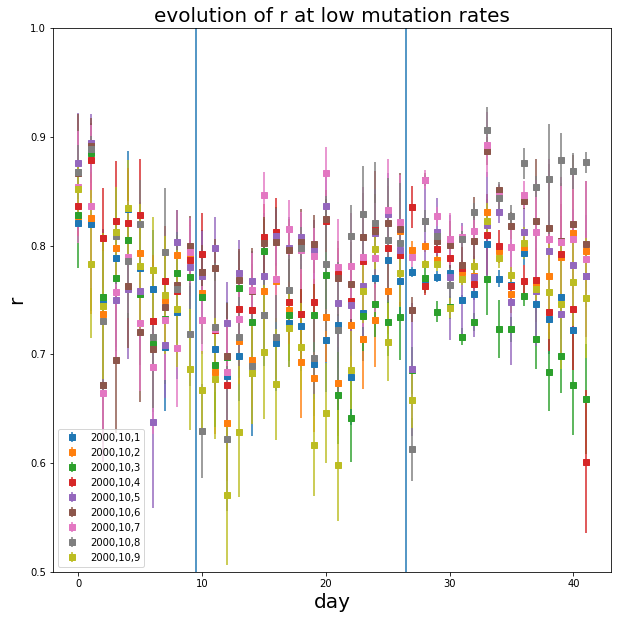

In [16]:
plt.figure(figsize=(10,10))
param = 1
for sample in ['2000,10,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pexps[sample][param], yerr=covexps[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of r at low mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('r', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
plt.legend()
plt.ylim(.5,1.0);

Or at high ones...

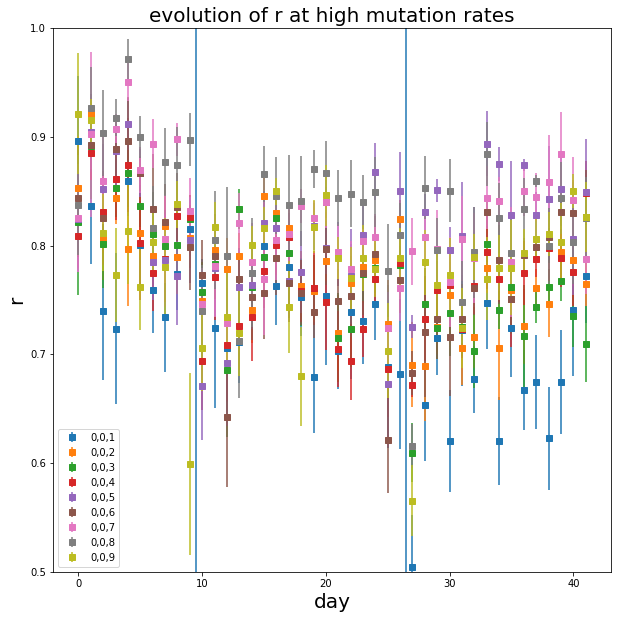

In [17]:
plt.figure(figsize=(10,10))
param = 1
for sample in ['0,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pexps[sample][param], yerr=covexps[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of r at high mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('r', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
plt.legend()
plt.ylim(.5,1.0);

## Evolution of saturating OD
<font size=\"1\">[Return to Table of Contents](#Table-of-Contents)</font>

The estimated saturating OD definitely evolves over time though at every set of mutation rates. There is a weird break in saturating OD between the first freeze and unfreeze though and I'm not sure what caused it. I'm pretty sure it is a systematic error and not a real effect.

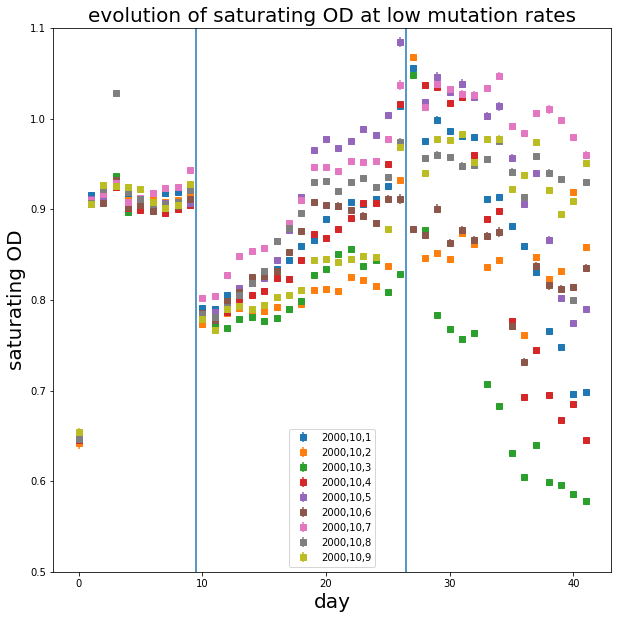

In [18]:
plt.figure(figsize=(10,10))
param = 2
for sample in ['2000,10,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pstas[sample][param], yerr=covstas[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of saturating OD at low mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('saturating OD', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
plt.legend();
plt.ylim(.5,1.1);

At low mutation rates, we see the saturating OD doesn't evolve much until about midway, at which replicates at first tend to have increases in carrying capacity. However after a bit of time, carrying capacity suddenly plummets. We'll see a similar pattern at higher mutation rates except it occurs quicker.

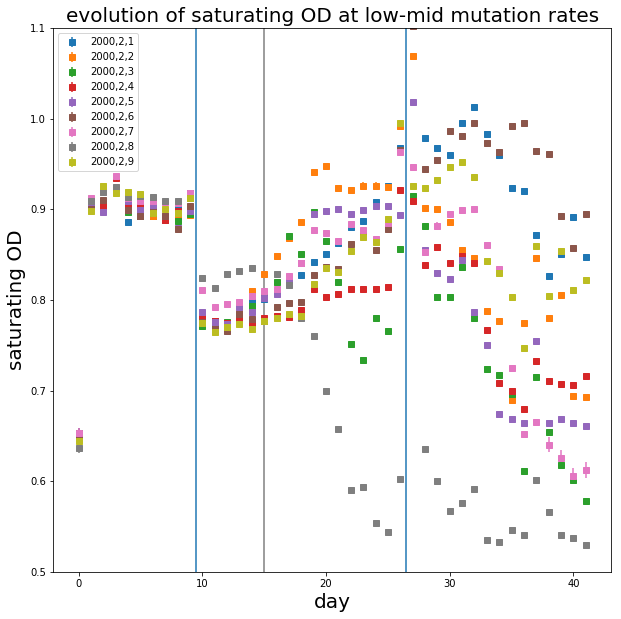

In [19]:
plt.figure(figsize=(10,10))
param = 2
for sample in ['2000,2,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pstas[sample][param], yerr=covstas[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of saturating OD at low-mid mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('saturating OD', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
plt.legend();
plt.ylim(.5,1.1);

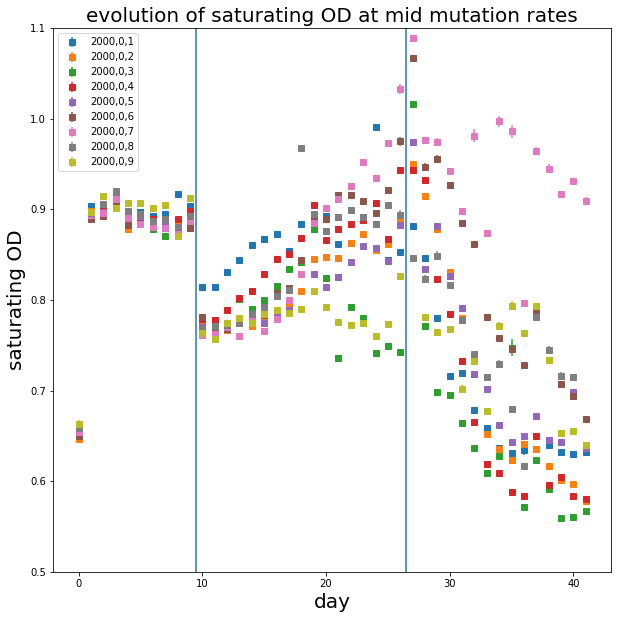

In [20]:
plt.figure(figsize=(10,10))
param = 2
for sample in ['2000,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pstas[sample][param], yerr=covstas[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of saturating OD at mid mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('saturating OD', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
plt.legend();
plt.ylim(.5,1.1);

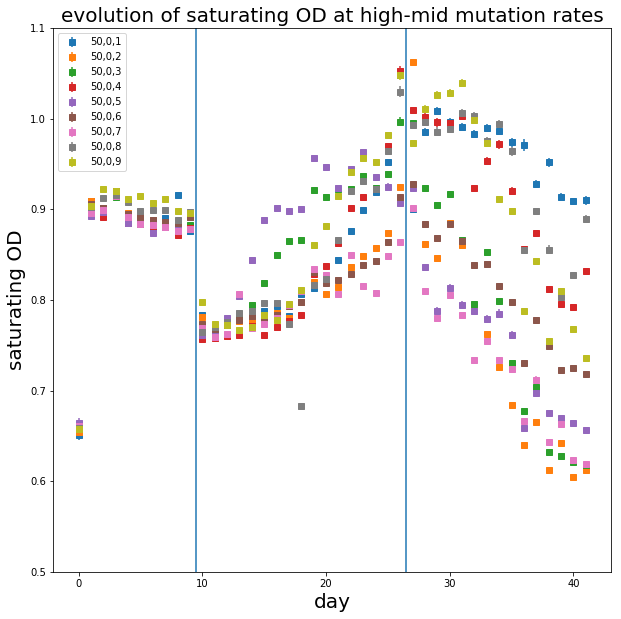

In [21]:
plt.figure(figsize=(10,10))
param = 2
for sample in ['50,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pstas[sample][param], yerr=covstas[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of saturating OD at high-mid mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('saturating OD', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
plt.legend();
plt.ylim(.5,1.1);

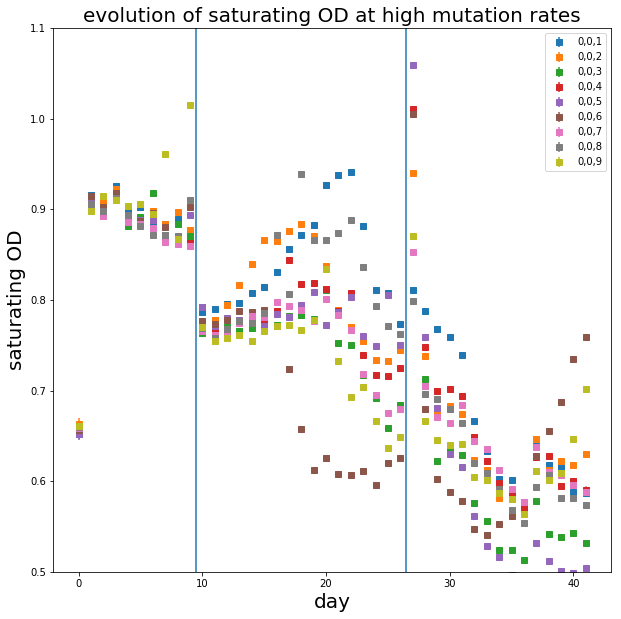

In [22]:
plt.figure(figsize=(10,10))
param = 2
for sample in ['0,0,'+str(i) for i in range(1,10)]:
    plt.errorbar(np.arange(42), pstas[sample][param], yerr=covstas[sample][param,param]**.5,
                 linestyle='', marker='s', label=sample)
plt.title('evolution of saturating OD at high mutation rates',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('saturating OD', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
plt.legend();
plt.ylim(.5,1.1);

At high mutation rates, carrying capacity decreases much faster. We can see this side by side if we average across replicates at a mutation rate.

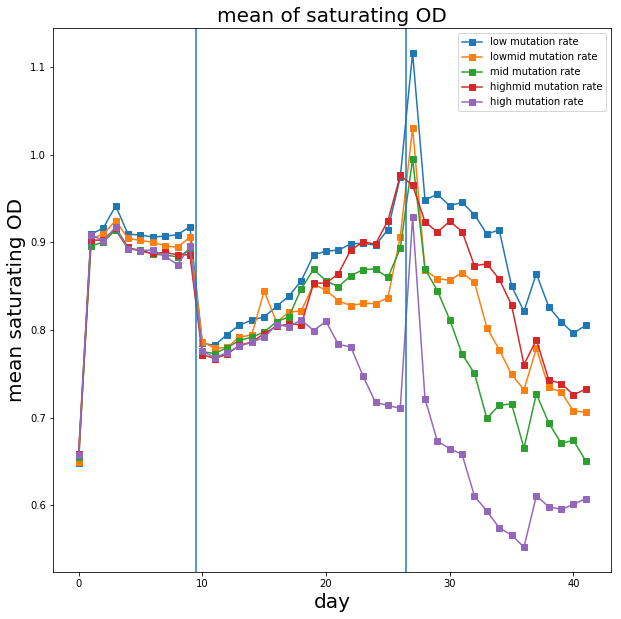

In [23]:
plt.figure(figsize=(10,10))
param = 2
K_lows = np.array([pstas[sample][param] for sample in ['2000,10,'+str(i) for i in range(1,10)]])
K_lowmids = np.array([pstas[sample][param] for sample in ['2000,2,'+str(i) for i in range(1,10)]])
K_mids = np.array([pstas[sample][param] for sample in ['2000,0,'+str(i) for i in range(1,10)]])
K_highmids = np.array([pstas[sample][param] for sample in ['50,0,'+str(i) for i in range(1,10)]])
K_highs = np.array([pstas[sample][param] for sample in ['0,0,'+str(i) for i in range(1,10)]])
plt.plot(np.arange(42), np.mean(K_lows,axis=0), linestyle='-', marker='s', label='low mutation rate')
plt.plot(np.arange(42), np.mean(np.minimum(K_lowmids,1.22),axis=0), linestyle='-', marker='s', label='lowmid mutation rate')
plt.plot(np.arange(42), np.mean(K_mids,axis=0), linestyle='-', marker='s', label='mid mutation rate')
plt.plot(np.arange(42), np.mean(K_highmids,axis=0), linestyle='-', marker='s', label='highmid mutation rate')
plt.plot(np.arange(42), np.mean(K_highs,axis=0), linestyle='-', marker='s', label='high mutation rate')
plt.title('mean of saturating OD',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('mean saturating OD', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
plt.legend();

Another important thing to note is that the coefficient of variation of saturating OD for a given mutation rate condition increases over time.

(0, 0.2)

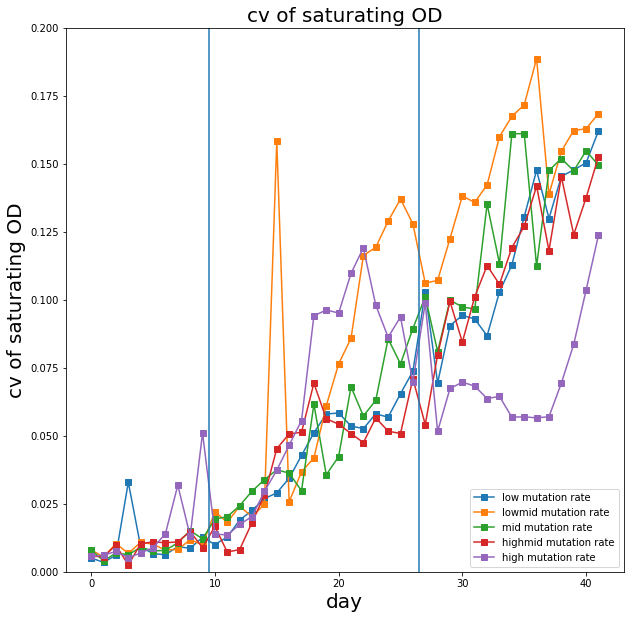

In [24]:
plt.figure(figsize=(10,10))
param = 2
K_lows = np.array([pstas[sample][param] for sample in ['2000,10,'+str(i) for i in range(1,10)]])
K_lowmids = np.array([pstas[sample][param] for sample in ['2000,2,'+str(i) for i in range(1,10)]])
K_mids = np.array([pstas[sample][param] for sample in ['2000,0,'+str(i) for i in range(1,10)]])
K_highmids = np.array([pstas[sample][param] for sample in ['50,0,'+str(i) for i in range(1,10)]])
K_highs = np.array([pstas[sample][param] for sample in ['0,0,'+str(i) for i in range(1,10)]])
plt.plot(np.arange(42), np.std(K_lows,axis=0)/np.mean(K_lows,axis=0), linestyle='-', marker='s', label='low mutation rate')
plt.plot(np.arange(42), np.std(np.minimum(K_lowmids,1.22),axis=0)/np.mean(np.minimum(K_lowmids,1.22),axis=0), linestyle='-', marker='s', label='lowmid mutation rate')
plt.plot(np.arange(42), np.std(K_mids,axis=0)/np.mean(K_mids,axis=0), linestyle='-', marker='s', label='mid mutation rate')
plt.plot(np.arange(42), np.std(K_highmids,axis=0)/np.mean(K_highmids,axis=0), linestyle='-', marker='s', label='highmid mutation rate')
plt.plot(np.arange(42), np.std(K_highs,axis=0)/np.mean(K_highs,axis=0), linestyle='-', marker='s', label='high mutation rate')
plt.title('cv of saturating OD',fontsize=20);
plt.xlabel('day', fontsize=20);
plt.ylabel('cv of saturating OD', fontsize=20);
plt.axvline(x=9.5);
plt.axvline(x=26.5);
plt.legend()
plt.ylim(0,.2)

So bottom line, growth rates don't evolve but saturating OD's do and the saturating OD evolves faster at higher mutation rates.

# Evolution of a single replicate's growth curves
<font size=\"1\">[Return to Table of Contents](#Table-of-Contents)</font>

What does evolution look like for the growth curves of a single replicate? We choose replicate '0,0,6' and start looking from day 10 after the first unfreeze.

For the first 6 days after unfreezing, the saturating OD is stagnant.

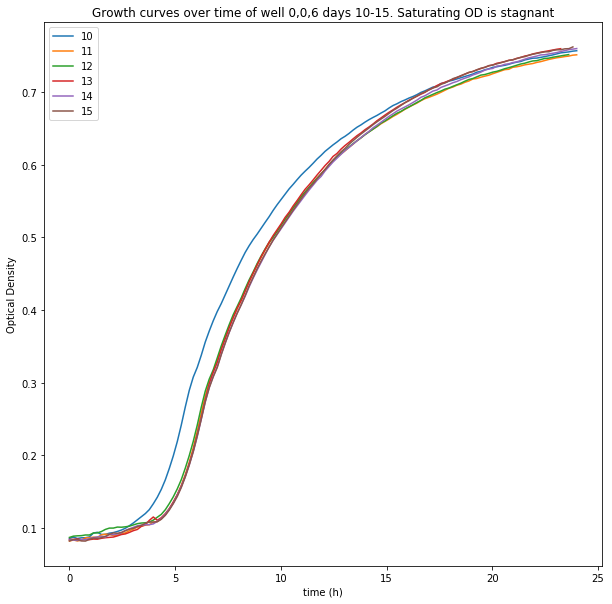

In [25]:
plt.figure(figsize=(10,10))
sample='0,0,6'
for i in range(10,16):
    t = days[i]['times']
    P = days[i]['well_ODs'][sample]
    plt.plot(t, P, label=str(i))
plt.xlabel('time (h)');
plt.ylabel('Optical Density');
plt.title('Growth curves over time of well 0,0,6 days 10-15. Saturating OD is stagnant');
plt.legend();

It then quickly decreases in 3 days.

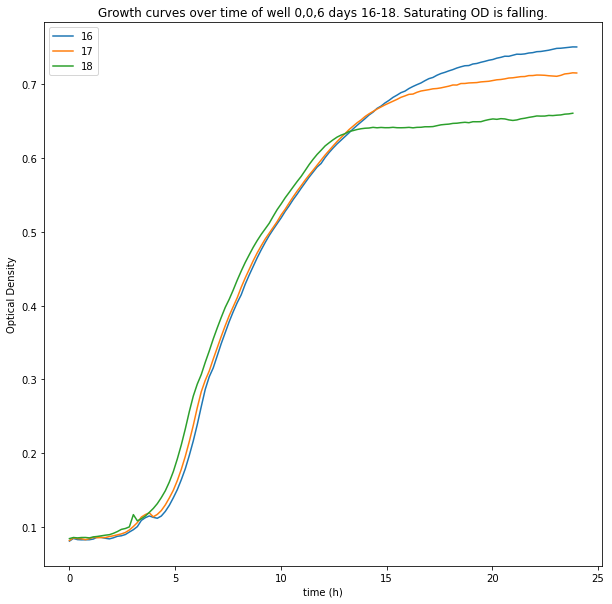

In [26]:
plt.figure(figsize=(10,10))
sample='0,0,6'
for i in range(16,19):
    t = days[i]['times']
    P = days[i]['well_ODs'][sample]
    plt.plot(t, P, label=str(i))
plt.xlabel('time (h)');
plt.ylabel('Optical Density');
plt.title('Growth curves over time of well 0,0,6 days 16-18. Saturating OD is falling.');
plt.legend();

This is followed by more stagnant evolution followed by a sudden jump after being unfrozen...

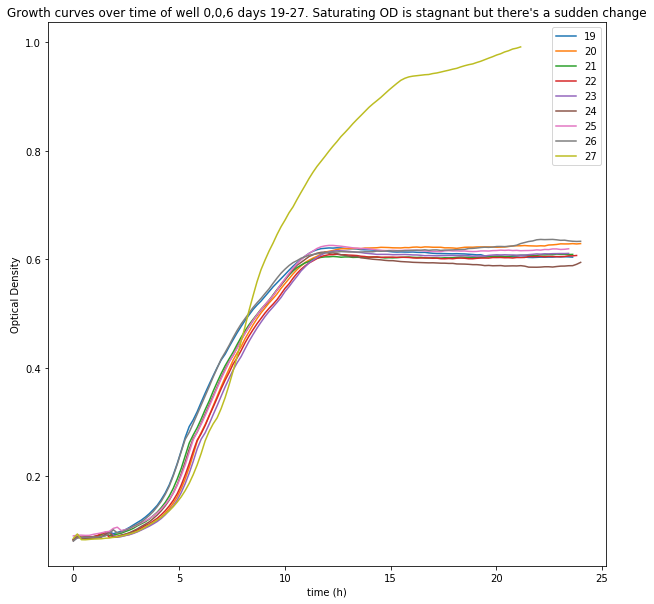

In [27]:
plt.figure(figsize=(10,10))
sample='0,0,6'
for i in range(19,28):
    t = days[i]['times']
    P = days[i]['well_ODs'][sample]
    plt.plot(t, P, label=str(i))
plt.xlabel('time (h)');
plt.ylabel('Optical Density');
plt.title("Growth curves over time of well 0,0,6 days 19-27. Saturating OD is stagnant but there's a sudden change");
plt.legend();

However, the jump appears to be a one day effect. And then we see a gradual decline in saturating optical density.

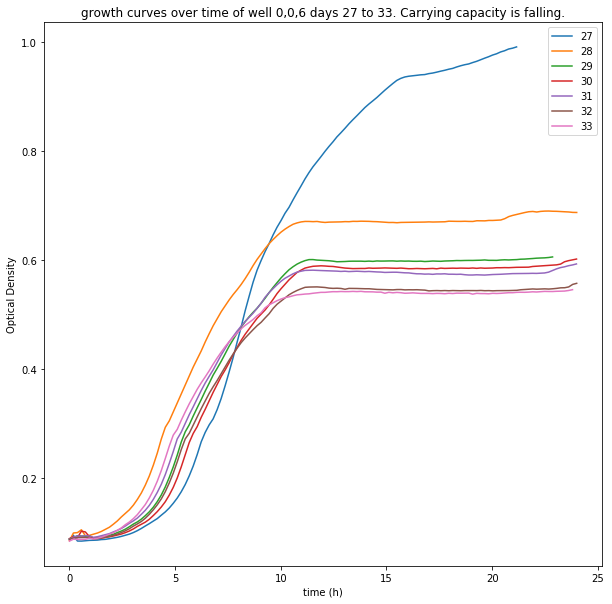

In [28]:
plt.figure(figsize=(10,10))
sample='0,0,6'
for i in range(27,34):
    t = days[i]['times']
    P = days[i]['well_ODs'][sample]
    plt.plot(t, P, label=str(i))
plt.xlabel('time (h)');
plt.ylabel('Optical Density');
plt.title('growth curves over time of well 0,0,6 days 27 to 33. Carrying capacity is falling.');
plt.legend();

However, this is followed by a reversal and saturating OD begins rising again.

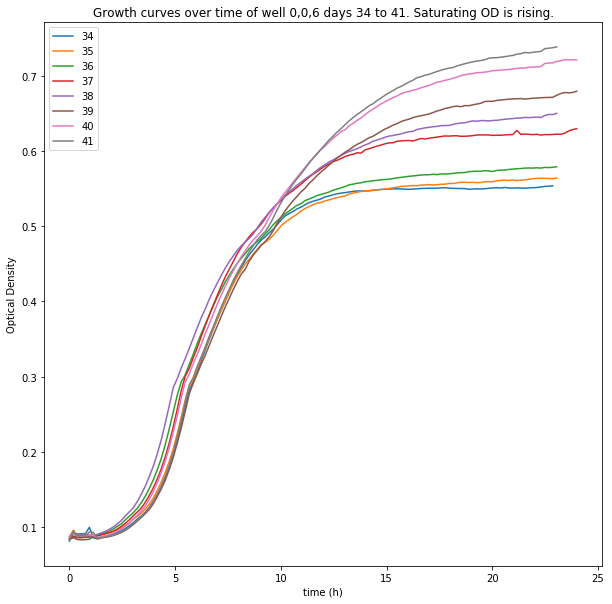

In [29]:
plt.figure(figsize=(10,10))
sample='0,0,6'
for i in range(34,42):
    t = days[i]['times']
    P = days[i]['well_ODs'][sample]
    plt.plot(t, P, label=str(i))
plt.xlabel('time (h)');
plt.ylabel('Optical Density');
plt.title('Growth curves over time of well 0,0,6 days 34 to 41. Saturating OD is rising.');
plt.legend();